<a href="https://colab.research.google.com/github/marianaketleyfer/Emerging-AI-Technologies-and-Sustainability/blob/main/Tweet_Sentiment_Analysis__DistilBERT_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sustainability Strategies and Evaluation for < Tweets Sentiment Analysis using Deep Learning >

---
This notebook explores sentiment analysis on the Sentiment140 dataset, focusing on consumer attitudes towards sustainable practices.

Dataset: https://www.kaggle.com/datasets/kazanova/sentiment140

# Initialization

## Loading all necessary imports

In [ ]:
!pip install datasets wordcloud pandarallel memory_profiler

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from operator import itemgetter
from tqdm.notebook import tqdm
from pandarallel import pandarallel

tqdm.pandas()
pandarallel.initialize(progress_bar=True)
plt.style.use('ggplot')

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Mounting Google drive to load remote .csv file locally

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading remote .csv into DataFrame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Verify the correct file path within your Google Drive
file_path = '/content/drive/My Drive/training.1600000.processed.noemoticon.csv'  # Adjust 'My Drive' if necessary

# Load the Sentiment140 dataset
df = pd.read_csv(
    file_path,
    encoding='ISO-8859-1',
    names=['target', 'ids', 'date', 'flag', 'user', 'text'],
    dtype={'target': 'int64', 'ids': 'int64'}
)

# Print first few rows to verify successful loading
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


### Displaying first 5 records

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Displaying the DataFrame's Columns info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


# Formatting the Data

## Defining custom methods for data formatting

### Creating a dictionary for common abbreviations

In [ ]:
chat_words_map_dict = {}
chat_words_list = []

chat_words_str = """
BRB: Be Right Back (often used when someone is going to get food)
BBQ: Barbecue
BF: Breakfast
BR: Brunch
DIN: Dinner
LUN: Lunch
MSG: Monosodium Glutamate (a flavor enhancer often mentioned in food contexts)
PPL: People (often used in the context of dining out with friends or a group)
PLS: Please (often used when ordering food)
YUM: Something tasty or delicious
GR8: Great (often used to describe a meal)
NP: No Problem (often used in the context of service or food requests)
OMW: On My Way (often used when heading to a restaurant)
K: OK (often used in food ordering and confirmations)
TY: Thank You (often used in the context of receiving food or service)
YW: You're Welcome (often used in the context of providing food or service)
CU: See You (often used when planning to meet at a restaurant)
FYI: For Your Information (often used to share food-related information)
HMU: Hit Me Up (often used to suggest going out for a meal)
ICYMI: In Case You Missed It (often used to share food-related news or deals)
IMO: In My Opinion (often used to share opinions about food or restaurants)
SUP: What's Up (often used to ask about dining plans)
F2T: Farm to Table (a movement promoting local food production)
GF: Gluten-Free
OR: Organic
V: Vegetarian
VGN: Vegan
NONGMO: Non-Genetically Modified Organism (indicating food products not containing GMOs)
CSA: Community Supported Agriculture (a system connecting producers and consumers)
EPA: Environmental Protection Agency (often involved in regulating agrotoxins)
FDA: Food and Drug Administration (regulating food safety)
FSA: Food Standards Agency (regulating food safety in some countries)
IFOAM: International Federation of Organic Agriculture Movements (promotes organic farming)
NOP: National Organic Program (regulates organic farming in the US)
PES: Pesticides (substances used for destroying insects or other organisms harmful to plants or animals)
RTB: Ready To Bake (food products ready for baking)
RTC: Ready To Cook (food products ready for cooking)
RTE: Ready To Eat (food products ready for consumption without further preparation)
CSA: Community Supported Agriculture (a system connecting producers and consumers to support local farming)
LOC: Locally Grown (food produced within a short distance of where it is consumed)
SFM: Sustainable Food Movement (promotes sustainable food practices)
PB: Plant-Based
WPB: Whole Plant-Based (diet emphasizing whole, unprocessed plant foods)
RAW: Raw Food (diet consisting mainly of uncooked, unprocessed foods)
NT: Nutritarian (diet focusing on nutrient-dense foods, often plant-based)
HCLF: High Carb Low Fat (diet focusing on high carbohydrate, low fat intake, often plant-based)
LCHF: Low Carb High Fat (diet focusing on low carbohydrate, high fat intake)
TF: Tofu (a common plant-based protein made from soybeans)
TVP: Textured Vegetable Protein (a plant-based protein often used in meat substitutes)
WW: Whole Wheat (used to indicate whole wheat products, often in bread and pasta)
FF: Fresh Food (emphasizing fresh, non-processed ingredients)
B12: Vitamin B12 (often mentioned in the context of vegan diets for supplementation)
OMEGA3: Omega-3 Fatty Acids (important for plant-based diets, often derived from flaxseeds, chia seeds, and algae)
"""

for line in chat_words_str.split("\n"):
    if line != "":
        cw, cw_expanded = line.split(":")
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded.strip()

## Converting text to lowercase

In [ ]:
df["text_lower"] = df["text"].str.lower()
df.head()

,target,ids,date,flag,user,text,text_lower
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@kenichan i dived many times for the ball. man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all...."


## Converting emoticons and emojis from lowercase text

In [ ]:
def convert_emojis(text):
    import re

    UNICODE_EMO = {
        "😋": "delicious",
        "😂": "laugh",
        "🤣": "laugh",
        "😍": "amazing",
        "😊": "happy",
        "😇": "happy",
        "🥰": "love",
        "😎": "cool",
        "🤩": "love",
        "🥳": "party",
        "🤪": "laugh",
        "😝": "sad",
        "😞": "sad",
        "😟": "sad",
        "😕": "confused",
        "🙁": "sad",
        "☹": "sad",
        "😣": "sad",
        "😖": "sad",
        "😫": "sad",
        "😩": "sad",
        "🥺": "sad",
        "😢": "sad",
        "😭": "sad",
        "😤": "angry",
        "😡": "angry",
        "😠": "angry",
        "🤬": "angry",
        "🤯": "mind",
        "😳": "disgust",
        "🥵": "disgust",
        "🥶": "disgust",
        "😱": "disgust",
        "😨": "disgust",
        "😰": "disgust",
        "😥": "sad",
        "😓": "sad",
        "🤗": "hug",
        "🤔": "confused",
        "🤭": "confused",
        "🤫": "confused",
        "🤥": "sad",
        "😶": "neutral",
        "😐": "neutral",
        "😑": "neutral",
        "😯": "happy",
        "😦": "sad",
        "😧": "sad",
        "😨": "sad",
        "😰": "sad",
        "😥": "sad",
        "😓": "sad",
        "🤗": "hug",
        "🤔": "confused",
        "🤭": "confused",
        "🤫": "confused",
        "🤥": "sad",
        "😶": "neutral",
        "😐": "neutral",
        "😑": "neutral",
        "😯": "happy",
        "😦": "sad",
        "😧": "sad",
        "😨": "sad",
        "😰": "sad",
        "😥": "sad",
        "😓": "sad",
        "🤗": "hug",
        "🤔": "confused",
        "🤭": "confused",
        "🤫": "confused",
        "🤥": "sad",
        "😶": "neutral",
        "😐": "neutral",
        "😑": "neutral",
        "😯": "happy",
        "😦": "sad",
        "😧": "sad",
        "😜": "Cool",
        "😝": "Cool",
        "🤪": "Crazy",
        "🤑": "Expansive",
        "🤑🤑": "Very Expansive",
        "🤑🤑🤑": "Extremely Expansive",
        "🤑🤑🤑🤑": "Extremely Expansive",
        "☹️": "frown",
        "😢": "sad",
        "😖": "frow",
        "🥹": "cute",
        "😮": "surprised",
        "😯": "surprise",
        "😲": "surprise",
        "😳": "disgust",
        "😍": "kiss",
        "😘": "kiss",
        "😘😘": "kiss",
        "😘😘😘": "kiss and love",
        "😏": "Tongue-in-cheek",
        "🤢": "being sick",
        "☠️": "dead",
        "❤️": "love",
        "👍": "thumbs up",
        "👎": "thumbs down",
        "🍻": "cheer's",
        "😵": "fainted",
        "🤨": "disapproval",
        "🧐": "disapproval",
        "😥": "sweat drop",
        "🙌": "joyful",
        "🙏": "thankful",
        "🤭": "Giggling",
        "🤫": "Shushing",
        "😀": "excited",
        "💃": "excited",
        "🕺": "excited",
        "🤙": "excited",
        "🔥": "spicy",
    }

    def convert_emojis(text):
        for convert_emojis in UNICODE_EMO:
            text = re.sub(r'('+convert_emojis+')', "_".join(UNICODE_EMO[convert_emojis].replace(",","").replace(":","").split()), text)
        return text

    return convert_emojis(convert_emojis(text))

df["text_lower"] = df["text_lower"].parallel_apply(convert_emojis)
df.head()

,target,ids,date,flag,user,text,text_lower
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@kenichan i dived many times for the ball. man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all...."


## Lemmatize all text


In [ ]:
nltk.download('wordnet')

def lemmatize_words(text):
    from nltk.stem import WordNetLemmatizer

    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["text_lemmatized"] = df["text_lower"].parallel_apply(lemmatize_words)
df = df.drop(columns=["text_lower"])
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,target,ids,date,flag,user,text,text_lemmatized
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@kenichan i dived many time for the ball. mana...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feel itchy and like it on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all...."


## Remove stopwords from lemmatized text

In [ ]:
nltk.download('stopwords')

def remove_stopwords(text):
    import nltk

    STOPWORDS = set(nltk.corpus.stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text_wo_stop"] = df["text_lemmatized"].parallel_apply(remove_stopwords)
df = df.drop(columns=["text_lemmatized"])
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,target,ids,date,flag,user,text,text_wo_stop
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset can't update facebook texting it... migh...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@kenichan dived many time ball. managed save 5...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, behaving all. i'm mad. he..."


In [ ]:
import nltk
nltk.download('stopwords')
import re

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+@', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    return text

def remove_stopwords(text):
    STOPWORDS = set(nltk.corpus.stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word.lower() not in STOPWORDS])

df["text_clean"] = df["text"].apply(clean_text)

df["text_wo_stop"] = df["text_clean"].apply(remove_stopwords)

df = df.drop(columns=["text_clean"])

df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,target,ids,date,flag,user,text,text_wo_stop
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",@switchfoot - that's bummer. shoulda got David...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset can't update Facebook texting it... migh...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@Kenichan dived many times ball. Managed save ...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, behaving all. i'm mad. he..."


## Formatted DataFrame info

#### Word Cloud Tweets

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(-0.5, 399.5, 199.5, -0.5)

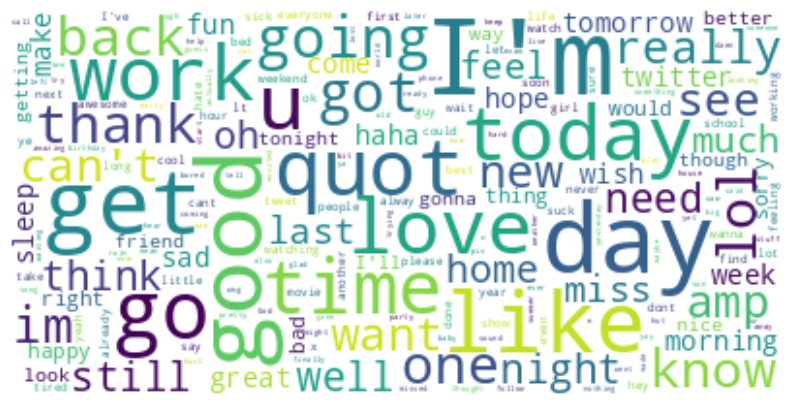

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords

nltk.download('stopwords')

wc = WordCloud(collocations=False, stopwords=set(stopwords.words('english')), max_font_size=55, background_color="white")

wc.generate(' '.join(df['text_wo_stop']))
plt.figure(figsize=(10,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

# Sentiment Analysis

## Green - AI Practices (DistilBERT tokenizer and Pruning Model)

In [ ]:
%load_ext memory_profiler

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.nn.utils import prune
from scipy.special import softmax
import nltk
from nltk.corpus import stopwords
import pandas as pd

nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

df['text_wo_stop'] = df['text'].map(remove_stopwords)

X = df['text_wo_stop']
y = df['target']

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define a function to apply pruning to the model
def prune_model(model):
    # Apply pruning to the linear layers
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.random_unstructured(module, name='weight', amount=0.2)  # Prune 20% of weights

prune_model(model)

@torch.autocast(device_type="cuda")
def get_polarity_scores_distilbert(texts):

    encoded_input = tokenizer(texts.tolist(), max_length=512, padding=True, truncation=True, return_tensors='pt')

    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    # Forward pass through the model with mixed precision
    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask)

    # Compute the softmax probabilities
    logits = output.logits.cpu().detach().numpy()
    probabilities = softmax(logits, axis=1)

    return probabilities

batch_size = 32
num_batches = len(df) // batch_size + 1

all_probabilities = []

for i in range(num_batches):
    batch_texts = df['text_wo_stop'][i*batch_size:(i+1)*batch_size]
    if not batch_texts.empty:
        probabilities = get_polarity_scores_distilbert(batch_texts)
        all_probabilities.extend(probabilities)

# Convert the list of probabilities into separate columns
prob_df = pd.DataFrame(all_probabilities, columns=['distil_neg', 'distil_neu', 'distil_pos'])
df = pd.concat([df.reset_index(drop=True), prob_df], axis=1)

# Memory usage profiling
%memit

output_filename = "sentiment_analysis_green.csv"
df.to_csv(output_filename, index=False)

df.head()


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


peak memory: 3489.02 MiB, increment: 0.00 MiB


,target,ids,date,flag,user,text,text_wo_stop,distil_neg,distil_neu,distil_pos,distil_neg,distil_neu,distil_pos
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - Awww, t...",0.334473,0.334717,0.331055,0.333984,0.312500,0.353516
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset can't update Facebook texting it... migh...,0.337646,0.340088,0.322510,0.329834,0.317871,0.352051
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@Kenichan I dived many times ball. Managed sav...,0.334961,0.336426,0.328369,0.337402,0.304199,0.358398
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire,0.335205,0.336426,0.328613,0.345703,0.304443,0.349854
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, behaving all. i'm mad. he...",0.331055,0.344727,0.323975,0.335938,0.305420,0.358643


### Plotting DistilBERT results

#### Polarity Comparative

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


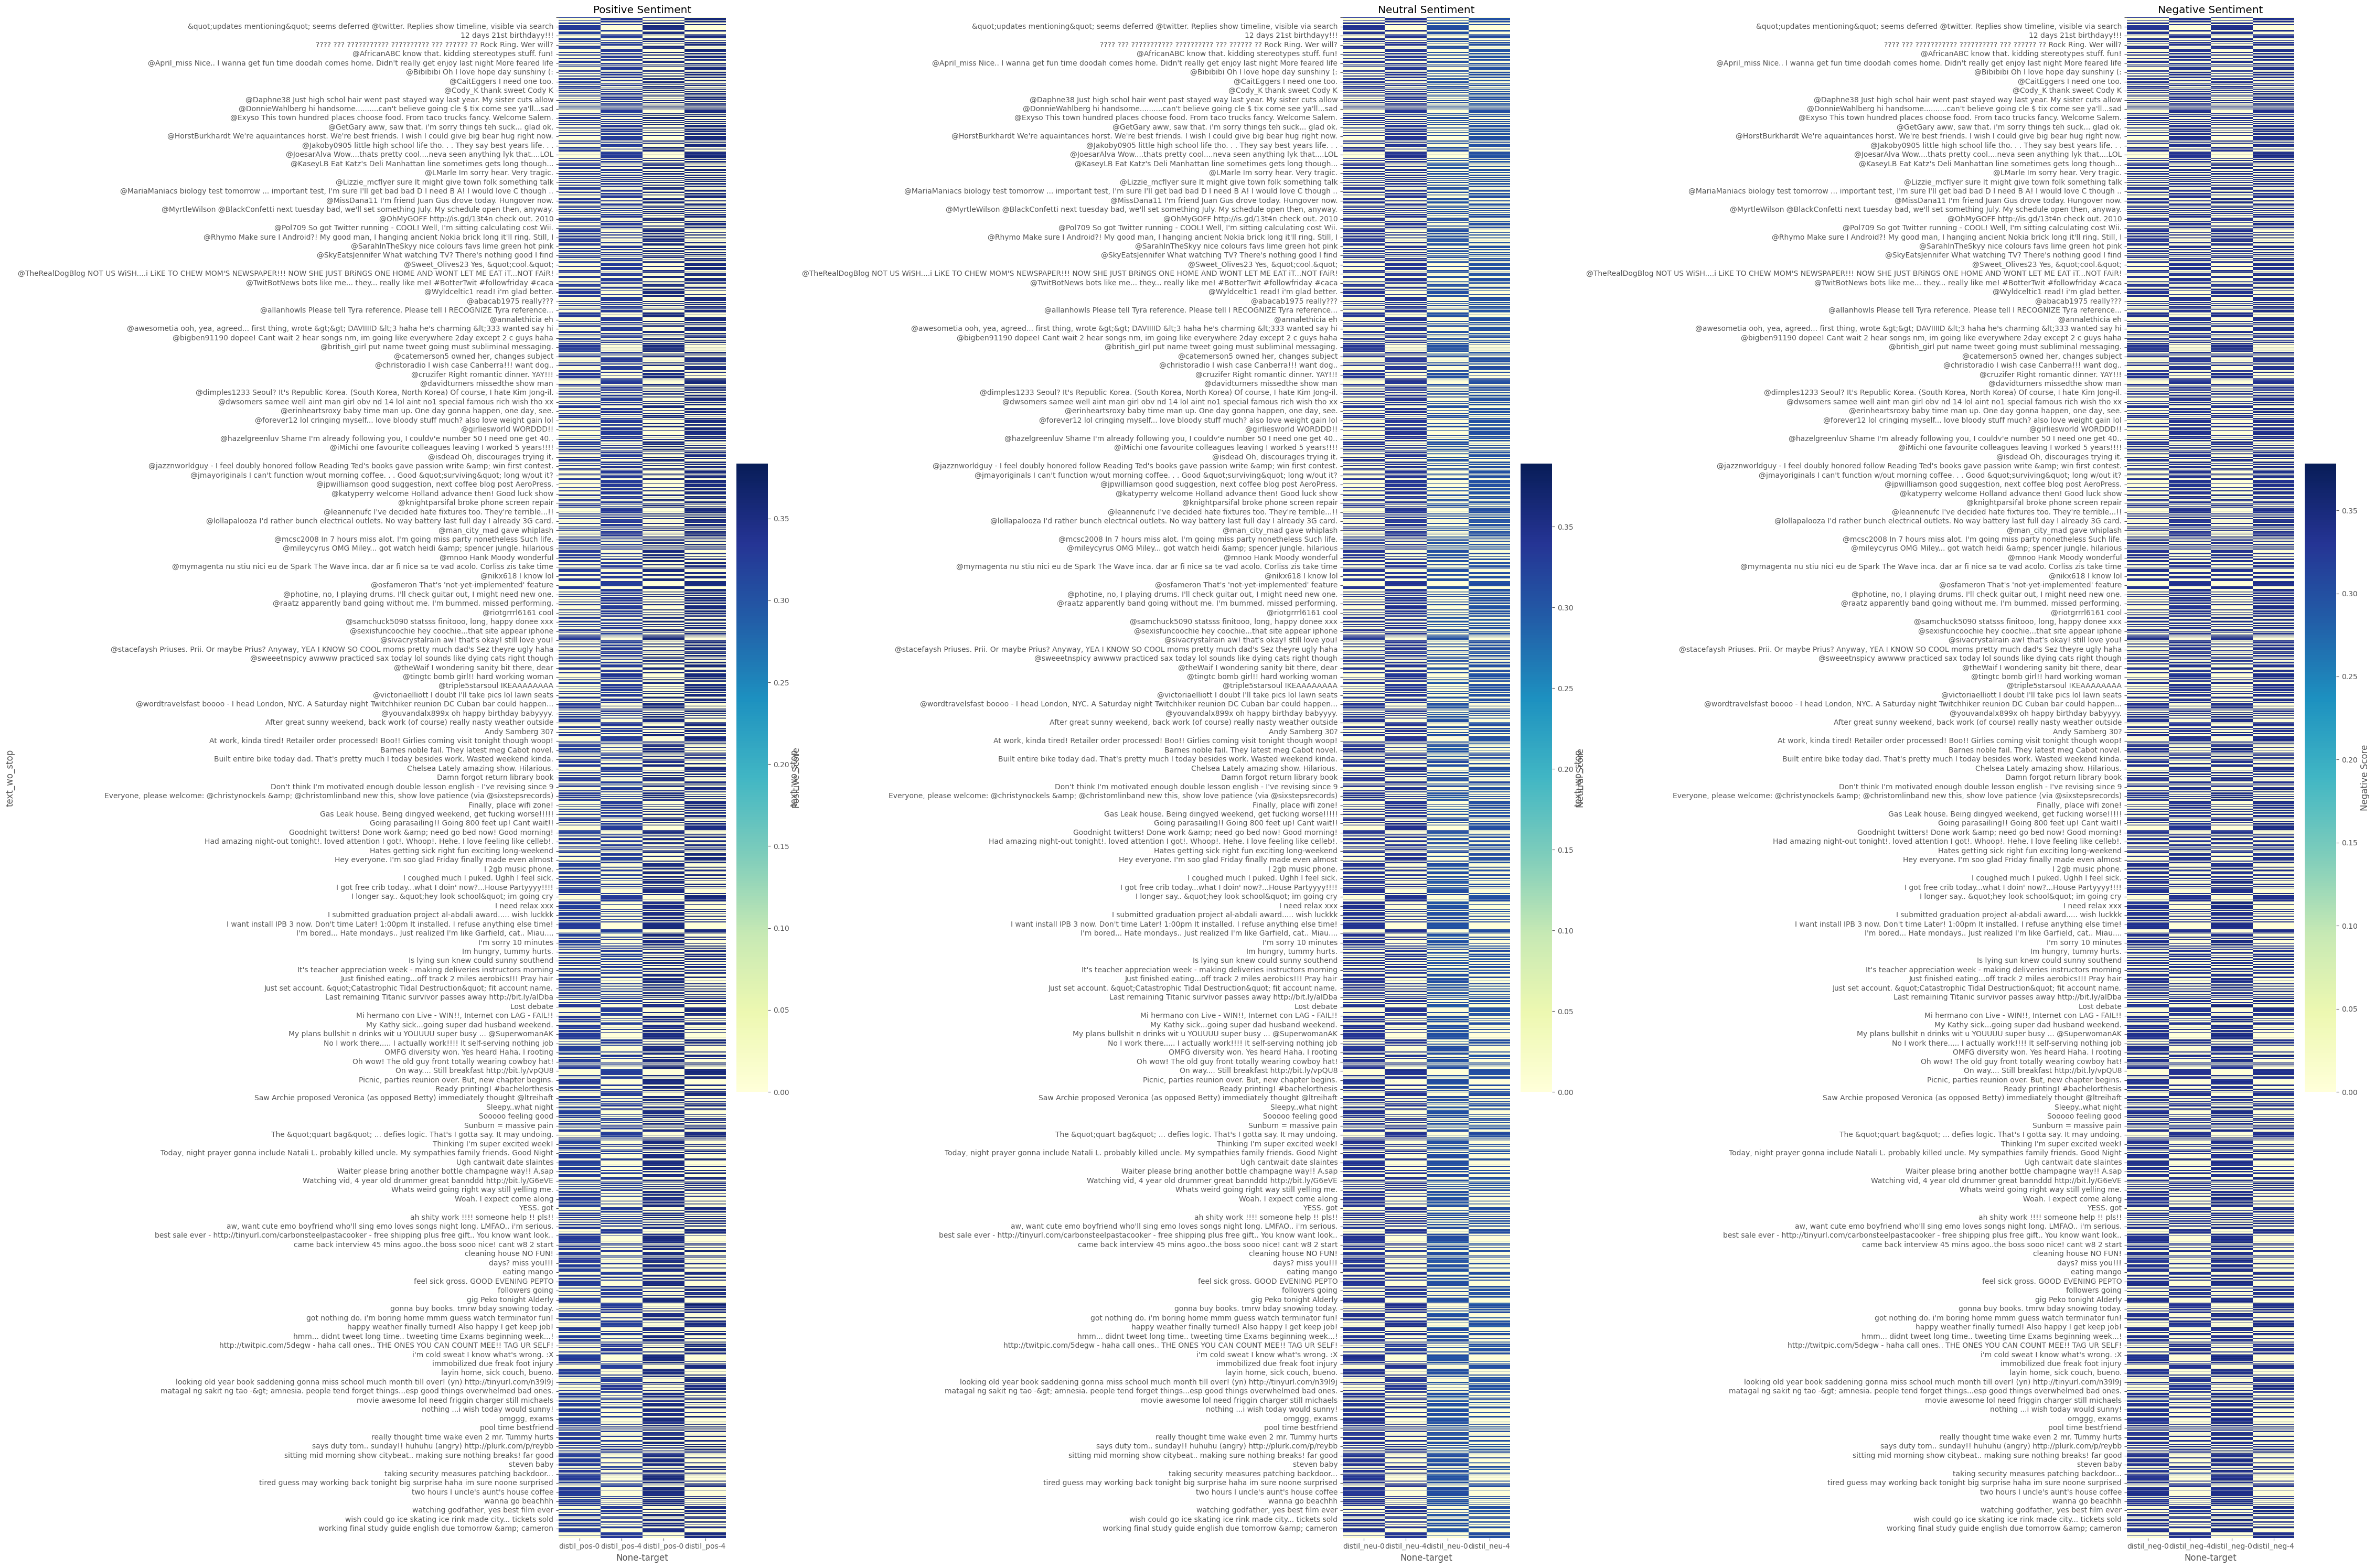

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

df['text_wo_stop'] = df['text'].map(remove_stopwords)

pos_pivot = df.groupby(['text_wo_stop', 'target'])['distil_pos'].mean().unstack(fill_value=0)
neu_pivot = df.groupby(['text_wo_stop', 'target'])['distil_neu'].mean().unstack(fill_value=0)
neg_pivot = df.groupby(['text_wo_stop', 'target'])['distil_neg'].mean().unstack(fill_value=0)

fig, axs = plt.subplots(1, 3, figsize=(45, 30))

sns.heatmap(pos_pivot, ax=axs[0], cmap="YlGnBu", cbar_kws={'label': 'Positive Score'}, annot=False, fmt=".2f")
axs[0].set_title('Positive Sentiment')

sns.heatmap(neu_pivot, ax=axs[1], cmap="YlGnBu", cbar_kws={'label': 'Neutral Score'}, annot=False, fmt=".2f")
axs[1].set_title('Neutral Sentiment')

sns.heatmap(neg_pivot, ax=axs[2], cmap="YlGnBu", cbar_kws={'label': 'Negative Score'}, annot=False, fmt=".2f")
axs[2].set_title('Negative Sentiment')

plt.tight_layout()
plt.show()



# Training & Test

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.nn.utils import prune
from scipy.special import softmax
import nltk
from nltk.corpus import stopwords
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

df['text_wo_stop'] = df['text'].map(remove_stopwords)

X = df['text_wo_stop']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000)),
    ('clf', LogisticRegression(solver='liblinear', max_iter=50))
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'tfidf__max_df': [0.7, 0.8],
    'clf__C': [0.1, 1]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)

print(f'Best Model Parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print('Classification Report:')
print(report)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Best Model Parameters: {'clf__C': 1, 'tfidf__max_df': 0.7}
Accuracy: 77.00%
Precision: 0.77
Recall: 0.77
F1-Score: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76    159494
           4       0.76      0.79      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



# Evaluation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 77.00%
Precision: 0.77
Recall: 0.77
F1-Score: 0.77
Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.75      0.76    159494
    Positive       0.76      0.79      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



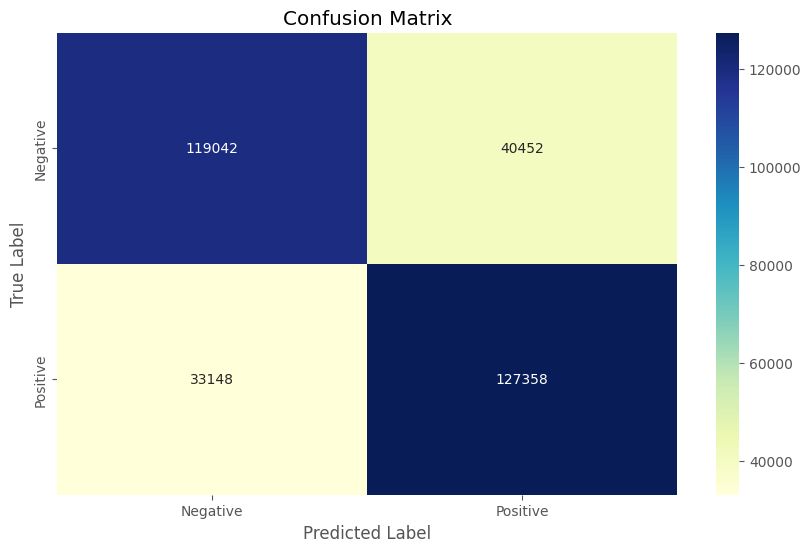

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.nn.utils import prune
from scipy.special import softmax
import nltk
from nltk.corpus import stopwords
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Load stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

df['text_wo_stop'] = df['text'].map(remove_stopwords)

X = df['text_wo_stop']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000)),  # Use up to 3000 features to save computation
    ('clf', LogisticRegression(solver='liblinear', max_iter=50))  # Reduced max_iter for efficiency
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'tfidf__max_df': [0.7, 0.8],
    'clf__C': [0.1, 1]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Test the model
y_pred = best_model.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate Precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.2f}')

# Calculate Recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall:.2f}')

# Calculate F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-Score: {f1:.2f}')

# Generate Classification Report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print('Classification Report:')
print(report)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
